In [ ]:
# exploring clinical variables

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
#establishing a connection to Dr. Luo's mimic database server, remember to connect to nu vpn first.

import psycopg2
# conn = psycopg2.connect(dbname="mimic", user="student", password="lipup", host="luolabwkstn01.fsm.northwestern.edu", port="5432")
# cur=conn.cursor()

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 2.32 s


In [3]:
import os
cwd= os.getcwd()

time: 1.01 ms


In [3]:
cwd

'/Users/geickelb1'

time: 3.28 ms


In [38]:
#importing clinical variable csv
#lab = f'data/interim/{today}-winemag_priceGBP.csv'

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/notebooks
final_pt_df2 = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/06072018_final_pt_df2.csv', index_col=0)
vaso_df = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/10072018_vaso_all_df.csv', index_col=0)


labs_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
labs_all48= labs_all48[labs_all48['label'].notnull()] #labs_all48 has some rows with null label... this removes them.

bg_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
vital_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/vital_all48_df.csv', index_col=0)
cohort_df = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)
#final_pt_df2 = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 14.1 s


In [39]:
#labs_all48.head()
pd.DataFrame(labs_all48).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv')

time: 8.59 s


In [ ]:
labs_all48

In [22]:
labs_all48.describe(include ='all', ) #the .T transposes the data. makes more sense. 

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
count,1.396199e+06,1.396199e+06,1.396199e+06,1354760,1354760,1.354746e+06
unique,NaN,NaN,NaN,192695,19,NaN
top,NaN,NaN,NaN,2141-04-15 20:12:00,POTASSIUM,NaN
freq,NaN,NaN,NaN,36,116162,NaN
mean,3.694985e+04,1.499390e+05,2.500838e+05,NaN,NaN,5.211095e+01
std,2.888935e+04,2.892039e+04,2.892764e+04,NaN,NaN,7.412202e+01
min,2.000000e+00,1.000010e+05,2.000010e+05,NaN,NaN,5.000000e-02
25%,1.359300e+04,1.249610e+05,2.249700e+05,NaN,NaN,5.500000e+00
50%,2.708900e+04,1.497480e+05,2.501520e+05,NaN,NaN,2.000000e+01
75%,5.988900e+04,1.749250e+05,2.750980e+05,NaN,NaN,9.600000e+01


time: 849 ms


In [47]:
(labs_all48.groupby(['label'])['valuenum','label'].describe())

#['subject_id','valuenum','label']

valuenum                                                      \
                count        mean         std    min    25%    50%    75%   
label                                                                       
ALBUMIN       15848.0    2.977044    0.672785   1.00    2.5    3.0    3.4   
ANION GAP     77703.0   14.765826    4.615240   2.00   12.0   14.0   17.0   
BANDS          5488.0   10.119625   10.354165   1.00    3.0    7.0   14.0   
BICARBONATE   79216.0   23.527600    5.514749   2.00   20.0   23.0   27.0   
BILIRUBIN     24141.0    2.709975    5.513684   0.10    0.4    0.8    2.3   
BUN           80542.0   32.205408   24.987569   1.00   15.0   24.0   42.0   
CHLORIDE      91528.0  104.720415    7.175859   1.70  100.0  105.0  109.0   
CREATININE    80822.0    1.826306    1.893652   0.05    0.8    1.2    2.0   
GLUCOSE      110745.0  145.446301   79.708047   1.55  103.0  127.0  163.0   
HEMATOCRIT   109928.0   30.705768    5.648967   4.00   27.0   30.1   34.0   
HEMOGLOBIN    91233.0   10.386708    1.973905   1.20    9.0   10.2   11.6   
INR           57096.0    1.705592    1.295775   0.10    1.2    1.3    1.7   
LACTATE       52350.0    2.897416    2.637821   0.05    1.3    2.0    3.4   
PLATELET      76649.0  212.137719  128.915616   5.00  123.0  190.0  271.0   
POTASSIUM    116161.0    4.234731    0.804294   0.70    3.7    4.1    4.6   
PT            57124.0   17.540767    9.351809   2.39   13.4   14.9   18.0   
PTT           58672.0   42.336277   25.462199  12.60   28.2   33.7   44.7   
SODIUM        95852.0  138.365344    5.639938  96.00  135.0  138.0  141.0   
WBC           73648.0   12.374483    9.549499   0.10    7.4   10.7   15.1   

                     
                max  
label                
ALBUMIN         5.7  
ANION GAP      77.0  
BANDS          86.0  
BICARBONATE    53.0  
BILIRUBIN      82.2  
BUN           272.0  
CHLORIDE      198.0  
CREATININE     46.6  
GLUCOSE      2440.0  
HEMATOCRIT     62.0  
HEMOGLOBIN     20.9  
INR            48.8  
LACTATE        32.0  
PLATELET     1608.0  
POTASSIUM      27.5  
PT            150.0  
PTT           150.0  
SODIUM        183.0  
WBC           471.7

time: 375 ms


# descriptive statistics for cohort. notes


get the missingness % for each variable (ie for each variable how many patients never have any entry?). repeat above for all variables. 

### NEED TO DOUBLE CHECK THAT THESE ICUSTAY ID ARE ONLY FOR THOSE INCLUDED IN STUDY



In [83]:
#labs_all48[1:1000].groupby(['subject_id', 'label'])['valuenum'].isnull()

#drop duplicates for all 

#s.isnull().sum()

lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

lab_na_testvar.value_counts()
#wine['country'].nunique()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

time: 13.5 ms


In [51]:
labs_all48['label'].isnull().sum()

AttributeError: Cannot access callable attribute 'isnull' of 'DataFrameGroupBy' objects, try using the 'apply' method

time: 10.1 ms


In [89]:
icustay_list= list(cohort_df['icustay_id'].unique())

time: 4.28 ms


In [103]:
#task: get the missingness % for each variable (ie for each variable how many patients never have any entry?)

#lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

#lab_na_testvar.value_counts()


####FIRST THINGS FIRST, FILTER ONLY TO ICUSTAY OF INTEREST.

labs_all48= labs_all48[labs_all48['icustay_id'].isin(icustay_list)] #good


#my strat, drop na from labs_all48, then drop duplicate for each patient lab.


labs_all48_notnull= labs_all48[labs_all48['valuenum'].notnull()]

#labs_all48_notnull.groupby(['subject_id'])['label'].count()
labs_all48_notnull.drop_duplicates(['subject_id','label'])['label'].value_counts()
#labs_all48['subject_id'].nunique()
#labs_all48['subject_id','icustay_id','charttime','label','valuenum'.dropna()

CHLORIDE       11415
GLUCOSE        11415
SODIUM         11415
POTASSIUM      11415
BUN            11414
CREATININE     11414
BICARBONATE    11410
HEMATOCRIT     11408
WBC            11406
PLATELET       11405
HEMOGLOBIN     11404
ANION GAP      11395
PT             10771
INR            10767
PTT            10738
LACTATE         8947
BILIRUBIN       7451
ALBUMIN         6457
BANDS           2626
Name: label, dtype: int64

time: 181 ms


In [136]:
%whos

Variable        Type             Data/Info
------------------------------------------
ConfigManager   MetaHasTraits    <class 'notebook.services<...>g.manager.ConfigManager'>
Counter         type             <class 'collections.Counter'>
Memory          type             <class 'sklearn.externals.joblib.memory.Memory'>
asyncio         module           <module 'asyncio' from '/<...>3.6/asyncio/__init__.py'>
bg_all48        DataFrame                 subject_id  hadm<...>1396199 rows x 6 columns]
cm              ConfigManager    <notebook.services.config<...>er object at 0x10ab9bc50>
cohort_df       DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
collections     module           <module 'collections' fro<...>collections/__init__.py'>
dt              type             <class 'datetime.datetime'>
final_pt_df2    DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
getpass         module           <module 'getpass' from '/<...>ib/python3.6/getpass.p

In [102]:
labs_all48_notnull['subject_id'].nunique()

11417

time: 13.7 ms


In [162]:
"""
    get the # of filled vs missign values for each variable for our cohort.
    Args:
    -----
    df: dataframe
        name of dataframe initialized in this workbook
    valuenum_col: string
        name of column with the numerical or text variable in question
    label_col: string
        name of column with the lab value label in question
    Returns:
    -----
    filled_summary: df
        list of all variables with # filled values
    missing_summary: df
        list of all variables with # missing values
    percent_summary: df
        list of all variables with # filled values/ # total patients
    """

def missing_fxn(df, valuenum_col, label_col):
    if 'icustay_id' in list(df):
        df= df[df['icustay_id'].isin(list(cohort_df['icustay_id'].unique()))] #good
    else:
        df= df[df['subject_id'].isin(
            list(cohort_df['subject_id'].unique()))] 

    df_notnull = df[df[valuenum_col].notnull()]
    df_null = df[df[valuenum_col].isnull()]
    df_filtered = df.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    
    filled_summary= df_notnull.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    missing_summary = df_null.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    percent_summary = 100*(filled_summary / df_filtered)
    
    #missing_plot=(missing_summary.sort_index().plot.bar(title = f'# of missing values in {df}'))
    
    #filled_summary, missing_summary, percent_summary, 
    return(filled_summary, missing_summary, percent_summary)

time: 22.1 ms


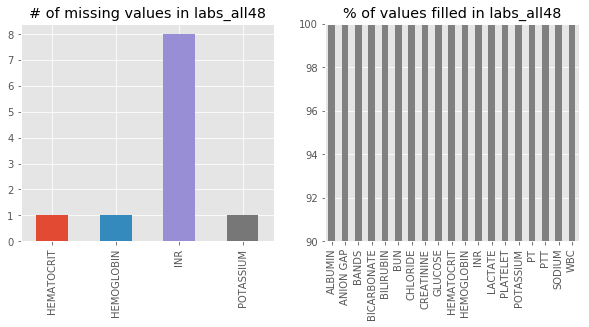

time: 795 ms


In [201]:
#labs
var1, var2, var3,  = missing_fxn(labs_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in labs_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

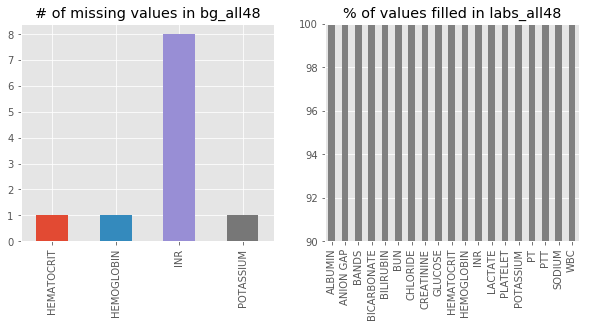

time: 721 ms


In [203]:
#bloodgas, is exact same as labs, 2xcheck
del var1, var2, var3
var1, var2, var3,  = missing_fxn(bg_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in bg_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

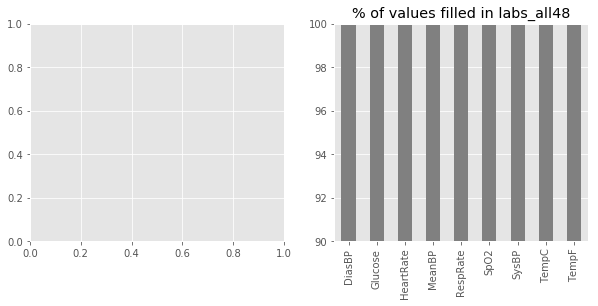

time: 2.08 s


In [223]:

del var1, var2, var3
var1, var2, var3,  = missing_fxn(vital_all48, 'valuenum', 'vitalid')
fig, axs = plt.subplots(1,2,figsize=(10,4))
if var2.notnull == True: 
    ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in vital_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))




In [ ]:
labs_by_pt

In [ ]:
# cnt = (wine.groupby(
#     ['country','points'])['price'].agg(['count','min','max','mean']
#                                       ).sort_values(by = 'mean',ascending = False)[:10]
# )



In [226]:
#bg_all48 #1396199 rows × 6 columns
#labs_all48 # 817014 rows × 6 columns
labs_all48.loc[labs_all48.loc[:,'label']=='BICARBONATE',:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
5,4,185777,294638,2191-03-16 05:42:00,BICARBONATE,21.0
21,4,185777,294638,2191-03-17 06:00:00,BICARBONATE,21.0
36,19,109235,273430,2108-08-06 01:08:00,BICARBONATE,22.0
51,19,109235,273430,2108-08-07 05:07:00,BICARBONATE,21.0
155,21,111970,216859,2135-01-30 19:05:00,BICARBONATE,23.0
173,21,111970,216859,2135-01-31 05:20:00,BICARBONATE,24.0
189,21,111970,216859,2135-02-01 02:59:00,BICARBONATE,20.0
204,25,129635,203487,2160-11-02 01:05:00,BICARBONATE,23.0
219,25,129635,203487,2160-11-02 03:59:00,BICARBONATE,21.0
230,25,129635,203487,2160-11-02 06:56:00,BICARBONATE,24.0


time: 189 ms


# VASO_DF EXPLORE

In [9]:
vaso_df.head()

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN


time: 17.4 ms


In [6]:
vaso_df.describe(include ='all', ).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
charttime,941,221,2163-04-09 15:15:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cv_rate_norepinephrine,672,NaN,NaN,NaN,0.1024,0.0745894,0,0.04,0.1,0.15,0.5
cv_rate_epinephrine,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cv_rate_dopamine,237,NaN,NaN,NaN,9.67089,2.33645,2,10,10,10,20
cv_rate_dobutamine,32,NaN,NaN,NaN,1.89062,1.20305,0,0.75,2.5,2.5,4
icustay_id,18992,NaN,NaN,NaN,249300,28450.5,200087,224474,249012,272764,299950
starttime,18992,17940,2144-08-27 00:50:00,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rate_norepinephrine,15329,NaN,NaN,NaN,0.176186,0.53856,0.0033003,0.060007,0.119102,0.224359,38.7485
rate_epinephrine,903,NaN,NaN,NaN,0.0923792,0.64535,0.00400014,0.0200091,0.0399918,0.0801056,19.2444
rate_dopamine,2454,NaN,NaN,NaN,9.75285,80.8013,0.499961,4.50076,6.0459,10.0168,4000


time: 222 ms


In [5]:
vaso_df.nunique()

charttime                   221
cv_rate_norepinephrine       24
cv_rate_epinephrine           0
cv_rate_dopamine              4
cv_rate_dobutamine            7
icustay_id                 1370
starttime                 17940
rate_norepinephrine       13821
rate_epinephrine            845
rate_dopamine              2060
rate_dobutamine             291
dtype: int64

time: 35.3 ms


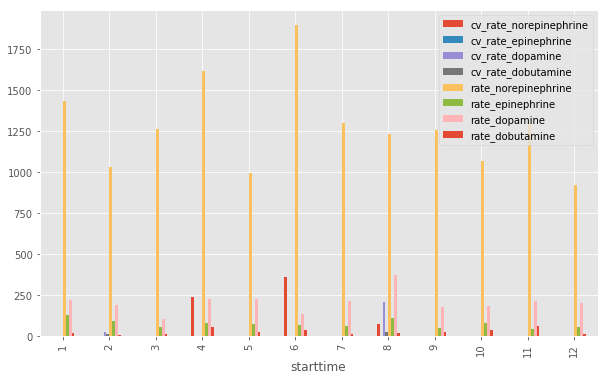

time: 422 ms


In [123]:
#To show the count of variables by month:
vaso_df['starttime']=pd.to_datetime(vaso_df['starttime'])

exclude_col= ['charttime','icustay_id','starttime']
vaso_df.loc[:, ~vaso_df.columns.isin(exclude_col)].groupby(test1["starttime"].dt.month).count().plot(kind="bar")

#interesting that so many cv_rate_norepinephrine's are in june and april. 

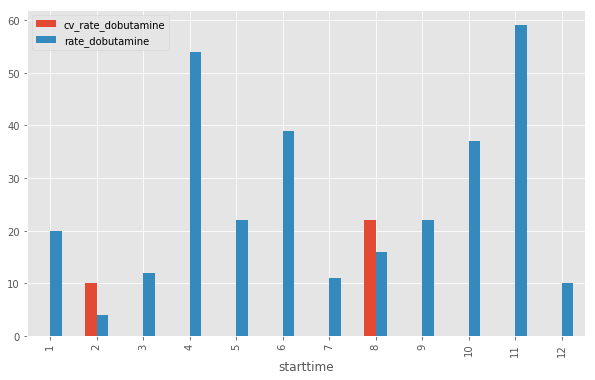

time: 227 ms


In [110]:
vaso_df.loc[:, vaso_df.columns.isin(['rate_dobutamine','cv_rate_dobutamine'])].groupby(vaso_df["starttime"].dt.month).count().plot(kind="bar")
#oops it would appear it is cv_rate_norepinephrine 

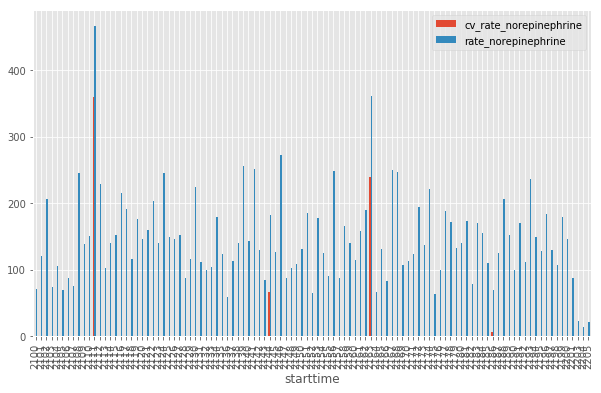

time: 1.28 s


In [136]:
vaso_df.loc[:, vaso_df.columns.isin(
    ['rate_norepinephrine','cv_rate_norepinephrine'])].groupby(
    vaso_df["starttime"].dt.year).count().plot(kind="bar")

#this is interesting, why do i only have cv_norepinephrine for certain years? 



In [135]:
table1= vaso_df.loc[:, vaso_df.columns.isin(
    ['cv_rate_norepinephrine'])].groupby(
    vaso_df["starttime"].dt.year).count()

table1.loc[table1.loc[:,'cv_rate_norepinephrine']!=0,:]
#strange that cv_rate_norepinephrine only occurs
#in 4 years: 2111, 2144, 2163, 2186. 

,cv_rate_norepinephrine
starttime,
2111,360
2144,66
2163,240
2186,6


time: 10.6 ms


In [126]:
vaso_df.loc[:, vaso_df.columns.isin(['cv_rate_norepinephrine'])].notnull().groupby(vaso_df["starttime"].dt.year).describe()

cv_rate_norepinephrine                   
                           count unique    top freq
starttime                                          
2100                          76      1  False   76
2101                         176      1  False  176
2102                         218      1  False  218
2103                         119      1  False  119
2104                         126      1  False  126
2105                         112      1  False  112
2106                          93      1  False   93
2107                          87      1  False   87
2108                         264      1  False  264
2109                         168      1  False  168
2110                         187      1  False  187
2111                         496      2   True  360
2112                         258      1  False  258
2113                         145      1  False  145
2114                         156      1  False  156
2115                         171      1  False  171
2116                         268      1  False  268
2117                         221      1  False  221
2118                         157      1  False  157
2119                         195      1  False  195
2120                         157      1  False  157
2121                         248      1  False  248
2122                         233      1  False  233
2123                         151      1  False  151
2124                         281      1  False  281
2125                         179      1  False  179
2126                         196      1  False  196
2127                         167      1  False  167
2128                         106      1  False  106
2129                         177      1  False  177
...                          ...    ...    ...  ...
2175                          91      1  False   91
2176                         106      1  False  106
2177                         256      1  False  256
2178                         187      1  False  187
2179                         177      1  False  177
2180                         191      1  False  191
2181                         257      1  False  257
2182                         112      1  False  112
2183                         204      1  False  204
2184                         162      1  False  162
2185                         145      1  False  145
2186                         121      2  False  115
2187                         143      1  False  143
2188                         266      1  False  266
2189                         172      1  False  172
2190                         111      1  False  111
2191                         214      1  False  214
2192                         144      1  False  144
2193                         299      1  False  299
2194                         182      1  False  182
2195                         150      1  False  150
2196                         248      1  False  248
2197                         184      1  False  184
2198                         161      1  False  161
2199                         219      1  False  219
2200                         213      1  False  213
2201                         131      1  False  131
2203                          23      1  False   23
2204                          16      1  False   16
2205                          40      1  False   40

[105 rows x 4 columns]

time: 327 ms


In [77]:
vaso_df.head()

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN


time: 107 ms


In [120]:
test1

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine,starttime_dt,starttime_strf,peroid,date
16,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 03:40:00,0.201088,NaN,NaN,NaN,2188-03-17 03:40:00,2188-03-17,2188-03,2188-03-17 03:40:00
17,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 09:00:00,0.140717,NaN,NaN,NaN,2188-03-17 09:00:00,2188-03-17,2188-03,2188-03-17 09:00:00
18,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:00:00,0.079198,NaN,NaN,NaN,2188-03-16 23:00:00,2188-03-16,2188-03,2188-03-16 23:00:00
19,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-16 23:30:00,0.105673,NaN,NaN,NaN,2188-03-16 23:30:00,2188-03-16,2188-03,2188-03-16 23:30:00
20,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 02:00:00,0.250631,NaN,NaN,NaN,2188-03-17 02:00:00,2188-03-17,2188-03,2188-03-17 02:00:00
21,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-18 10:30:00,0.040342,NaN,NaN,NaN,2188-03-18 10:30:00,2188-03-18,2188-03,2188-03-18 10:30:00
22,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-18 11:30:00,0.030286,NaN,NaN,NaN,2188-03-18 11:30:00,2188-03-18,2188-03,2188-03-18 11:30:00
23,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 17:32:00,0.074594,NaN,NaN,NaN,2188-03-17 17:32:00,2188-03-17,2188-03,2188-03-17 17:32:00
24,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 10:00:00,0.084662,NaN,NaN,NaN,2188-03-17 10:00:00,2188-03-17,2188-03,2188-03-17 10:00:00
25,NaN,NaN,NaN,NaN,NaN,236368.0,2188-03-17 00:29:00,0.200434,NaN,NaN,NaN,2188-03-17 00:29:00,2188-03-17,2188-03,2188-03-17 00:29:00


time: 49.4 ms


In [146]:
#visualizing serum lactate

#is lactate in lab same as serum lactate?

#(labs_all48.groupby(['label'])['valuenum','label'].describe())
#labs_all48["charttime"])= labs_all48(pd.to_datetime(vaso_df["charttime"])

labs_all48.loc[labs_all48.loc[:,'label']=='LACTATE',:].groupby(labs_all48(pd.to_datetime(labs_all48["charttime"]).dt.year).count().plot(kind="bar"))

#labs_all48.head()
#.groupby(vaso_df["starttime"].dt.year).count().plot(kind="bar")

TypeError: 'DataFrame' object is not callable

time: 431 ms


# comparing epinephrine extracted from sofa score modified sql and from epinephrine dose sql

In [127]:
#epinephrine dose

"""
n=2216
"""
epi_dose_df= pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/13072018_epi_dose_df.csv')
#epinephrine sofa

#melting vaso_df to make it easier to highlight only epinephrine
vaso_df_melted=vaso_df.melt(
    id_vars=['charttime', 'icustay_id','starttime'])[
    vaso_df.melt(id_vars=['charttime', 'icustay_id','starttime'])[
        'value'].notnull()]
#epinephrine sofa 
"""
n=903
"""

epi_sofa=vaso_df_melted.loc[
    vaso_df_melted.loc[:,'variable'].isin([
        'cv_rate_epinephrine','rate_epinephrine']),:]


print(epi_sofa.shape,epi_dose_df.shape )

time: 64 ms


#notes:
- epi_dose_df['vaso_rate'] == epi_sofa['value']   #these are equal. 

In [131]:
epi_dose_df.head()
epi_dose_df.loc[epi_dose_df.loc[:,'icustay_id']==289413.0,:]

,Unnamed: 0,icustay_id,starttime,endtime,vaso_rate,vaso_amount
1923,6956,289413.0,2118-09-20 17:00:00,2118-09-20 18:56:00,0.030009,0.342183


time: 9.21 ms


In [130]:
epi_sofa.head()
epi_sofa.loc[epi_sofa.loc[:,'icustay_id']==289413.0,:]


,charttime,icustay_id,starttime,variable,value
95068,NaN,289413.0,2118-09-20 17:00:00,rate_epinephrine,0.030009


time: 9.63 ms


In [135]:
val= np.intersect1d(epi_dose_df["icustay_id"], epi_sofa["icustay_id"])
print (len(val)) #only 164 overlap...

val2= np.intersect1d(epi_sofa["icustay_id"],epi_dose_df["icustay_id"])

print (len(val2)) #n=164 overlap

print(epi_sofa["icustay_id"].nunique(),epi_dose_df["icustay_id"].nunique() ) #AH, only 164 unique icustay id's in epi_sofa and 414 in epi_dose_df
#good news is every icustay_id in epi_dose is in epi_sofa!


164
164
164 414
time: 10.1 ms


# density plot tinkering

In [ ]:
#example code
# List of five airlines to plot
airlines = ['United Air Lines Inc.', 'JetBlue Airways', 'ExpressJet Airlines Inc.'',
         'Delta Air Lines Inc.', 'American Airlines Inc.']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = flights[flights['name'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Delay (min)')
plt.ylabel('Density')

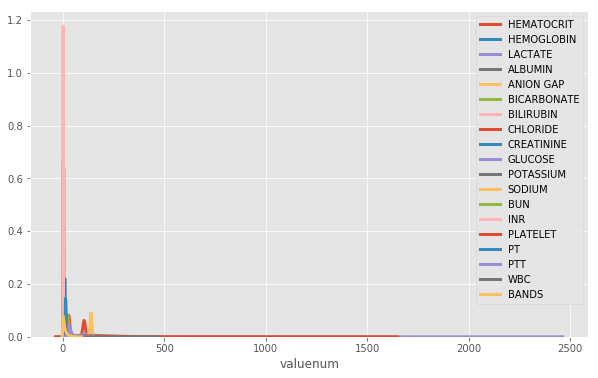

time: 33.4 s


In [201]:
#get the clinical variable
for var in labs_all48['label'].unique():
    subset = labs_all48[labs_all48['label']==var]
    sns.distplot(subset.loc[(subset['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
                 hist = False, 
                 kde = True, 
                 kde_kws = {'linewidth': 3},label = var)

plt.show()
    
#     plt.figure()
#     sns.countplot(subset)
# plt.legend(prop={'size': 16}, title = 'Lab Test')
# plt.title('Value num for tests in labs_all48')
# plt.xlabel('valuenum (units change)')
# plt.ylabel('Density')

    #sns.distplot(labs_all48[labs_all48['label']=='LACTATE']['charttime'].astype("datetime64").dt.month, hist = False, kde = True, kde_kws = {'linewidth': 3},label = var)
    


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: 'AxesSubplot' object is not callable

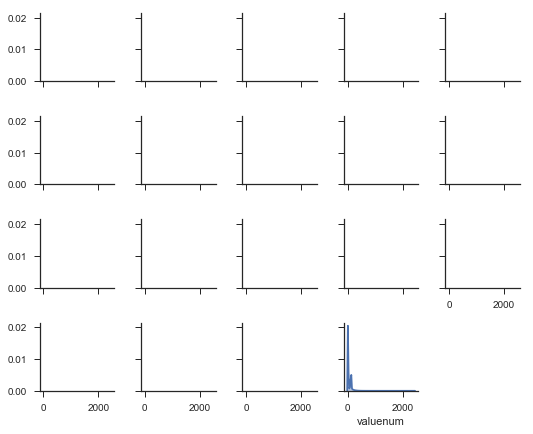

time: 10.7 s


In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Create a dataset with many short random walks
# rs = np.random.RandomState(4)
# pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
# pos -= pos[:, 0, np.newaxis]
# step = np.tile(range(5), 20)
# walk = np.repeat(range(20), 5)
# df = pd.DataFrame(np.c_[pos.flat, step, walk],
#                   columns=["position", "step", "walk"])


# for var in labs_all48['label'].unique():
#     subset = labs_all48[labs_all48['label']==var]
#     sns.distplot(subset.loc[(subset['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
#                  hist = False, 
#                  kde = True, 
#                  kde_kws = {'linewidth': 3},label = var)


lab_notnul= labs_all48[labs_all48['valuenum'].notnull()]

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(lab_notnul, col="label", #hue="walk",
                     col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.distplot(lab_notnul['valuenum']),hist = False, kde = True, kde_kws = {'linewidth': 3})
    
#    plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)

In [45]:
testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].unique()

array([1.9, 0.4, 0.3, 0.2, 0.9, 0.7, 1.7, 2.3, 5.9, 4.7, 0.8, 1. ])

time: 5.28 ms


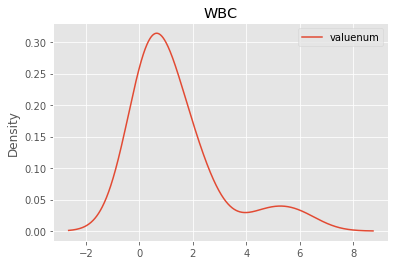

time: 160 ms


In [47]:
testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].plot(kind='kde',legend=True, title=title)

In [60]:
#testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'].min() 
#hmm the kde is not approximating them very well


# sns.distplot(testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN','valuenum'], hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})


#df = pd.read_pickle('data.pkl')
#df.columns = ['timestamp', 'senderId']

import ggplot

plot = ggplot(aes(x = 'valuenum'), data= testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN',['valuenum','label']])
plot = plot + geom_density()
print(plot)

NameError: name 'aes' is not defined

time: 10.7 ms


In [65]:
import rpy2

time: 605 µs


In [67]:
make_r_df

Object `make_r_df` not found.
time: 2.34 ms


In [72]:

r_df = make_r_df(testdf2.loc[testdf2.loc[:,'label']=='BILIRUBIN',['valuenum','label']])
r.pdf("plot.pdf")

#a<- ggplot(labs_all48, aes(x=valuenum)) #+ geom_density()

#a + facet_wrap(~ label, scales = "free") + geom_density(aes(color = label)) 

p = ggplot2.ggplot(r_df, aes(x=valuenum)) + geom_density()
p.plot()

NameError: name 'make_r_df' is not defined

time: 148 ms


In [74]:
#using ggplot2 in jupyter
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic

import rpy2.ipython

%reload_ext rpy2.ipython

# We need ggplot2

%R require(ggplot2)
%R library("ggplot2")
# Load in the pandas library
import pandas as pd 
# Make a pandas DataFrame
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
# Take the name of input variable df and assign it to an R variable of the same name
%R -i df
# Plot the DataFrame df
#ggplot(data=df) + geom_point(aes(x=A, y=B, color=C))
%R print(ggplot(data=df) + geom_point(aes(x=A, y=B, color=C)))

AttributeError: 'NoneType' object has no attribute 'name'

time: 34.6 ms


NameError: name 'library' is not defined

time: 8.02 ms


In [58]:
ggplot?

time: 53.2 ms


Type:        module
String form: <module 'ggplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ggplot/__init__.py'>
File:        ~/anaconda/envs/rpy-env/lib/python3.6/site-packages/ggplot/__init__.py
Docstring:   <no docstring>


#Notice that a wider bandwidth results in more smoothing of the distribution. We also see that even though we limited our data to -60 to 120 minutes, the density plot extends beyond these limits. This is one potential issue with a density plot: because it calculates a distribution at each data point, it can generate data that falls outside the bounds of the original data. This might mean that we end up with impossible values on the x-axis that were never present in the original data! As a note, we can also change the kernel, which changes the distribution drawn at each data point and thus the overall distribution. However, for most applications, the default kernel, Gaussian, and the default bandwidth estimation work very well.

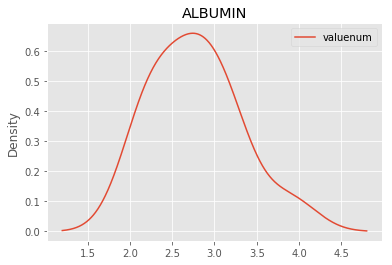

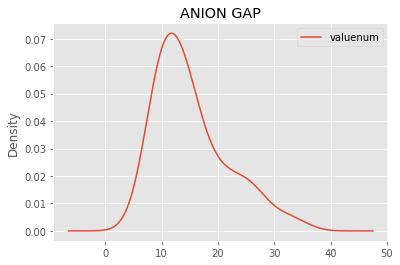

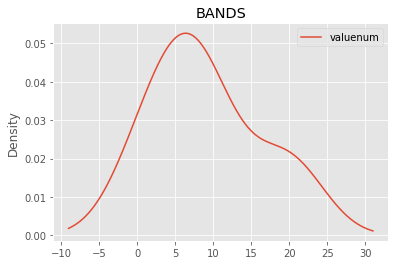

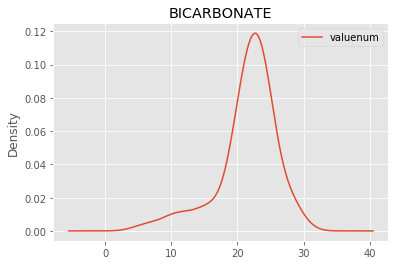

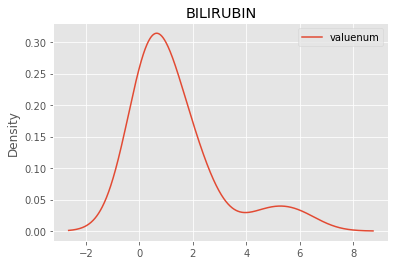

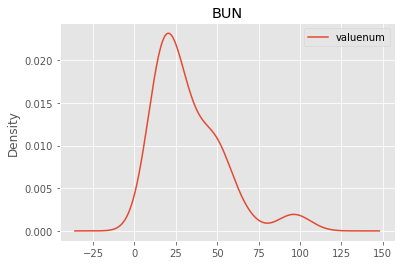

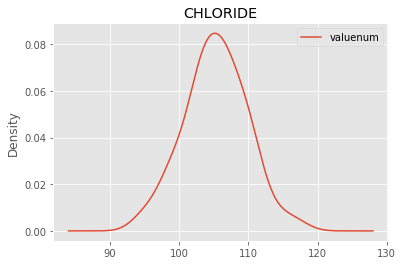

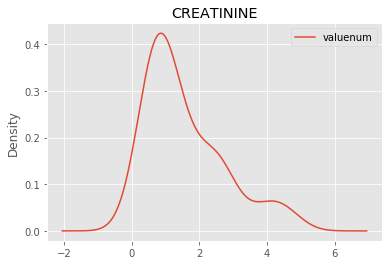

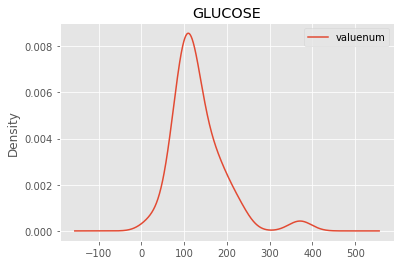

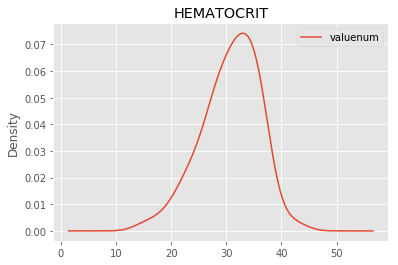

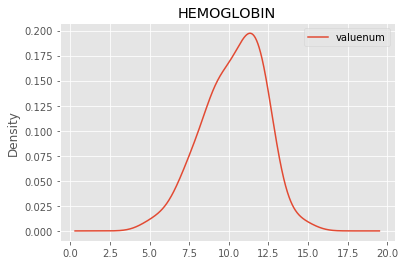

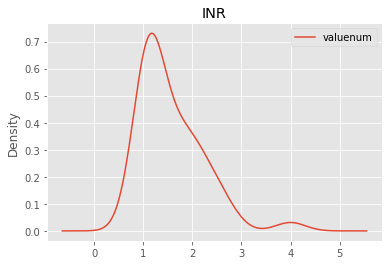

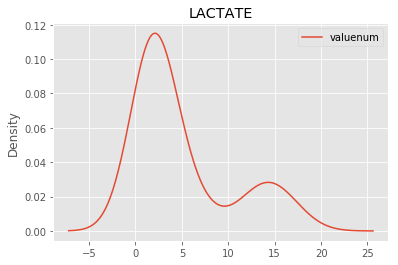

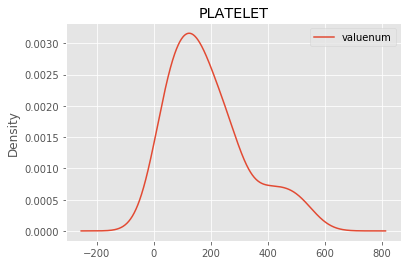

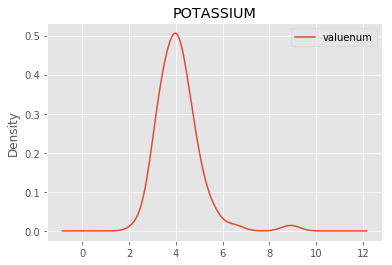

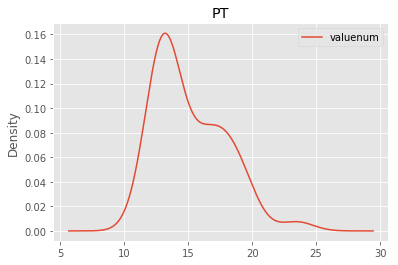

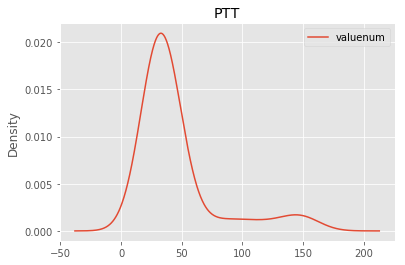

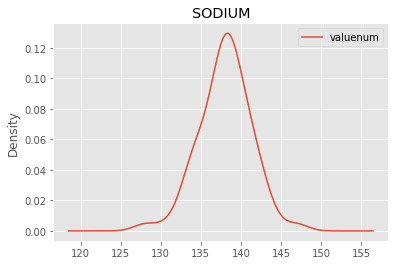

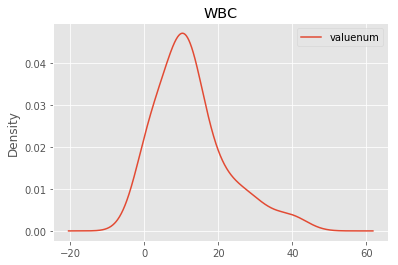

time: 2.9 s


In [37]:
testdf2= labs_all48.iloc[1:1000,:]
#testdf2.groupby('label')['valuenum'].plot(kind='density', legend=True)

for title, group in testdf2.groupby('label'):
    group[['valuenum','label']].plot(kind='density', legend=True, title=title)

In [18]:
testdf2[['label','valuenum','icustay_id']]

,label,valuenum,icustay_id
1,HEMOGLOBIN,10.5,294638
2,LACTATE,2.1,294638
3,ALBUMIN,2.8,294638
4,ANION GAP,15.0,294638
5,BICARBONATE,21.0,294638
6,BILIRUBIN,1.9,294638
7,CHLORIDE,108.0,294638
8,CREATININE,0.5,294638
9,GLUCOSE,183.0,294638
10,POTASSIUM,3.3,294638


time: 16.7 ms


In [ ]:
labs_all48.iloc[1:100,:]

In [8]:
labs_all48.iloc[1:100,:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
1,4,185777,294638,2191-03-15 21:23:00,HEMOGLOBIN,10.5
2,4,185777,294638,2191-03-15 21:23:00,LACTATE,2.1
3,4,185777,294638,2191-03-16 05:42:00,ALBUMIN,2.8
4,4,185777,294638,2191-03-16 05:42:00,ANION GAP,15.0
5,4,185777,294638,2191-03-16 05:42:00,BICARBONATE,21.0
6,4,185777,294638,2191-03-16 05:42:00,BILIRUBIN,1.9
7,4,185777,294638,2191-03-16 05:42:00,CHLORIDE,108.0
8,4,185777,294638,2191-03-16 05:42:00,CREATININE,0.5
9,4,185777,294638,2191-03-16 05:42:00,GLUCOSE,183.0
10,4,185777,294638,2191-03-16 05:42:00,POTASSIUM,3.3


time: 24.2 ms


Text(0,0.5,'Density')

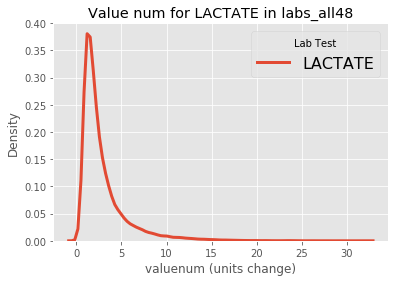

time: 440 ms


In [41]:
#first test that all plots for labels work:
#lactate  
#density plot
var='LACTATE'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

Text(0,0.5,'Density')

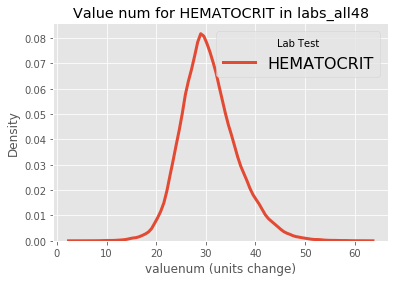

time: 529 ms


In [42]:
var='HEMATOCRIT'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [ ]:
var='HEMATOCRIT'
sns.distplot(labs_all48.loc[(labs_all48['label']==var) & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for %s in labs_all48' %(var))
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

#failed plotting stuff:
    still haven't figured out how to plot multiple graphs on the same line or in a grid that have different axes or without manual coding of them in subplots.
    #would be really nice to be able to just generate all density fxns for each label in 

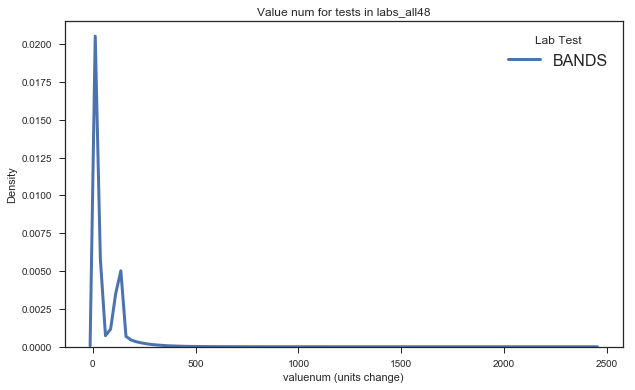

time: 7.05 s


In [208]:
sns.distplot(labs_all48.loc[(labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')
plt.show()

In [7]:
import seaborn as sns
g = sns.FacetGrid(labs_all48.loc[(labs_all48['valuenum'].notnull()),:].groupby('label)', col='label', col_wrap=3, palette="Set1")
g.map(sns.distplot, "valuenum", hist=False, rug=True)

SyntaxError: invalid syntax (<ipython-input-7-03d0d1a8bb5d>, line 3)

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


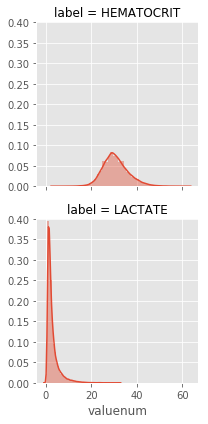

time: 983 ms


In [38]:
#pairgrid

testdf= labs_all48[(labs_all48['valuenum'].notnull()) & (labs_all48['label'].isin(['LACTATE','HEMATOCRIT']))][['label','valuenum','icustay_id']]

# g= sns.PairGrid(testdf, x_vars=['valuenum'], y_vars=['Density'],hue='label', size=4)
# g.map(sns.distplot, 'valuenum', color='0.3')


g=sns.FacetGrid(testdf, row='label')
g.map(sns.distplot, 'valuenum')#, hist=False, rug=True)
plt.show()

In [19]:
labs_all48[(labs_all48['valuenum'].notnull()) & (labs_all48['label'].isin(['LACTATE','HEMATOCRIT']))][['label','valuenum','icustay_id']]

,label,valuenum,icustay_id
0,HEMATOCRIT,32.0,294638
2,LACTATE,2.1,294638
13,HEMATOCRIT,31.8,294638
28,HEMATOCRIT,31.7,294638
43,HEMATOCRIT,36.5,273430
58,HEMATOCRIT,36.4,273430
62,LACTATE,1.2,273430
63,HEMATOCRIT,27.0,217847
82,HEMATOCRIT,33.4,217847
90,LACTATE,1.9,217847


time: 59.6 ms


Text(0,0.5,'Density')

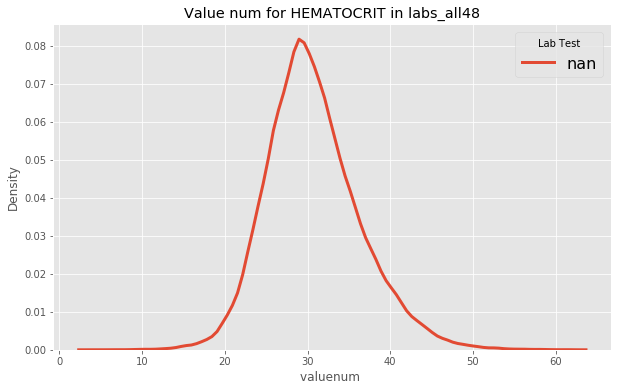

time: 670 ms


In [200]:
#HEMATOCRIT  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='HEMATOCRIT') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for HEMATOCRIT in labs_all48')
plt.xlabel('valuenum ')
plt.ylabel('Density')

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [ ]:
#lactate  
#density plot
sns.distplot(labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]['valuenum'], 
             hist = False, 
             kde = True, 
             kde_kws = {'linewidth': 3},label = var)
#plot formatting
plt.legend(prop={'size': 16}, title = 'Lab Test')
plt.title('Value num for tests in labs_all48')
plt.xlabel('valuenum (units change)')
plt.ylabel('Density')

In [191]:
#labs_all48[labs_all48['label']=='LACTATE']['charttime'].astype("datetime64").dt.month
#labs_all48[labs_all48['label']=='LACTATE']


#labs_all48.loc[(labs_all48['label']=='LACTATE') & (labs_all48['valuenum'].notnull()),:]
for var in labs_all48['label'].unique():
    print(var)


HEMATOCRIT
HEMOGLOBIN
LACTATE
ALBUMIN
ANION GAP
BICARBONATE
BILIRUBIN
CHLORIDE
CREATININE
GLUCOSE
POTASSIUM
SODIUM
BUN
INR
PLATELET
PT
PTT
WBC
BANDS
nan
time: 86.6 ms


In [197]:
labs_all48= labs_all48[labs_all48['label'].notnull()]

time: 118 ms


# code graveyard

In [ ]:
#broken code for plotting the datetimes

#vaso_df['starttime'].value_counts().sort_index().plot.bar(color = 'mediumvioletred', title = 'starttime historgram for vaso_df');

#--------#
# #pd.to_datetime(ABrx_16sterile_ntnul['startdate']

# # Define your own bins
# mybins = range(vaso_df['starttime_strf'].min(), vaso_df['starttime_strf'].max(), 10)

# # Cut the data with the help of the bins
# vaso_df['age_bucket'] = pd.cut(vaso_df['starttime_strf'], bins=mybins)

# # Count the number of values per bucket
# vaso_df['age_bucket'].value_counts()

#--------#
# #len(ABrx_ntnull['icustay_id'].unique())

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# test1['peroid'].sort_values(ascending=True).plot.hist(100)

#--------#

# import pandas as pd
# vaso_df['starttime_dt']=pd.to_datetime(vaso_df['starttime'])
# vaso_df['starttime_strf']= vaso_df['starttime_dt'].dt.strftime('%Y-%m-%d')

#--------#
#trying to get starttime to peroids by month
#from datetime import datetime
#import numpy as np
#from pandas.tseries.offsets import BDay
#test1=pd.to_datetime(vaso_df.starttime)
# test1=vaso_df
# dates= pd.DatetimeIndex(test1['starttime'])
# test1['peroid']=dates.to_period('M')


In [5]:
"""
    get the # of filled vs missign values for each variable for our cohort.
    Args:
    -----
    df: dataframe
        name of dataframe initialized in this workbook
    valuenum_col: string
        name of column with the numerical or text variable in question
    label_col: string
        name of column with the lab value label in question
    Returns:
    -----
    filled_summary: df
        list of all variables with # filled values
    missing_summary: df
        list of all variables with # missing values
    percent_summary: df
        list of all variables with # filled values/ # total patients
    """

def missing_fxn(df, valuenum_col, label_col):
    if 'icustay_id' in list(df):
        df= df[df['icustay_id'].isin(list(cohort_df['icustay_id'].unique()))] #good
    else:
        df= df[df['subject_id'].isin(
            list(cohort_df['subject_id'].unique()))] 

    df_notnull = df[df[valuenum_col].notnull()]
    df_null = df[df[valuenum_col].isnull()]
    df_filtered = df.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    
    filled_summary= df_notnull.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    missing_summary = df_null.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    percent_summary = 100*(filled_summary / df_filtered)
    
    #missing_plot=(missing_summary.sort_index().plot.bar(title = f'# of missing values in {df}'))
    
    #filled_summary, missing_summary, percent_summary, 
    return(filled_summary, missing_summary, percent_summary)

time: 22.7 ms


In [ ]:
#labs
var1, var2, var3,  = missing_fxn(labs_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in labs_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

In [136]:
list(final_pt_df2.columns)

['subject_id',
 'icustay_id',
 'hadm_id',
 't_0_sc',
 't_end_sc',
 'ab_course',
 't_0',
 't_end_consec',
 'dod_hosp',
 'dod_ssn',
 'dod_delta',
 'org_list',
 'spec_type_list',
 'sc_result',
 'final_bin']

time: 35.2 ms


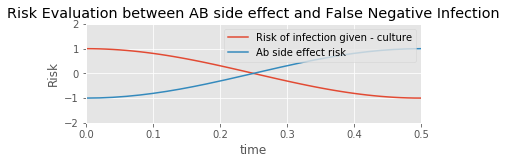

time: 318 ms


In [2]:
from matplotlib.pyplot import figure, show
from numpy import arange, sin, cos,tan, pi

t = arange(0.0, 1.0, 0.01)
z = arange(0.0, 2.0, 0.01)
fig = figure(1)

ax1 = fig.add_subplot(211)
ax1.plot(t, cos(2*pi*t))
ax1.plot(z, -cos(2*pi*z))
ax1.grid(True)
ax1.set_ylim((-2, 2))
ax1.set_xlim((0, 0.5))
ax1.set_ylabel('Risk')
ax1.set_xlabel('time')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')

ax1.legend(('Risk of infection given - culture', 'Ab side effect risk',), loc= 'upper right')



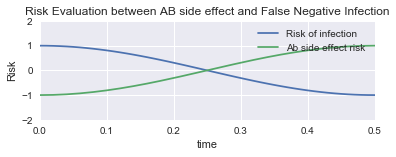

time: 151 ms


In [6]:
from matplotlib.pyplot import figure, show
from numpy import arange, sin, cos,tan, pi

t = arange(0.0, 1.0, 0.01)
z = arange(0.0, 2.0, 0.01)
fig = figure(1)

ax1 = fig.add_subplot(211)
ax1.plot(t, cos(2*pi*t))
ax1.plot(z, -cos(2*pi*z))
ax1.grid(True)
ax1.set_ylim((-2, 2))
ax1.set_xlim((0, 0.5))
ax1.set_ylabel('Risk')
ax1.set_xlabel('time')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')
ax1.set_title('Risk Evaluation between AB side effect and False Negative Infection')

ax1.legend(('Risk of infection', 'Ab side effect risk',), loc= 'upper right')



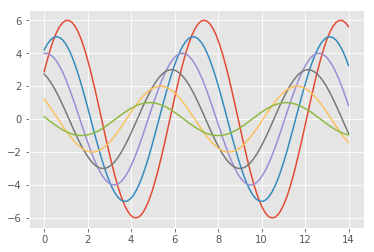

time: 164 ms


In [4]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)

sinplot()

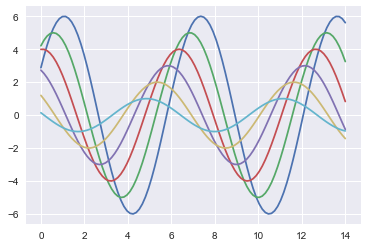

time: 128 ms


In [5]:
sns.set()
sinplot()

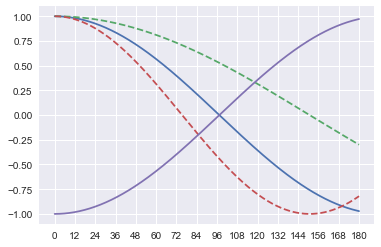

time: 156 ms


In [43]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 180, 1000)
ax.plot(x, np.cos((1/62)*x), linestyle='-')
ax.plot(x, np.cos((1/96)*x), linestyle='--')
ax.plot(x, np.cos((1/48)*x), linestyle='--')
ax.plot(x, -np.cos((1/62)*x), linestyle='-')
plt.xticks(np.arange(min(x), max(x)+1, 12));

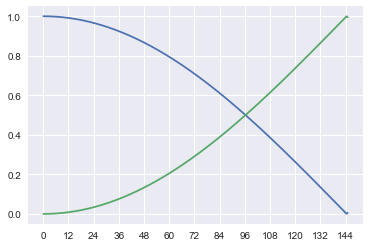

time: 123 ms


In [56]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 145, 1000)
ax.plot(x, abs(np.cos((1/92)*x)), linestyle='-')
ax.plot(x, 1+ -abs(np.cos((1/92)*x)), linestyle='-')
plt.xticks(np.arange(min(x), max(x)+1, 12));

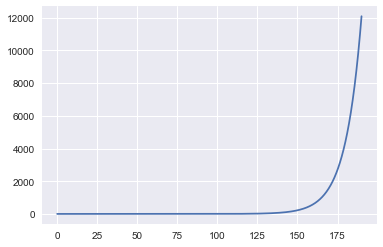

time: 125 ms


In [107]:
from scipy.special import expit
from numpy import exp

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 190, 1000)
xt=96
k=0.1
ax.plot(x, (1/(np.exp(-k*(x-xt)))))

<Figure size 432x288 with 0 Axes>

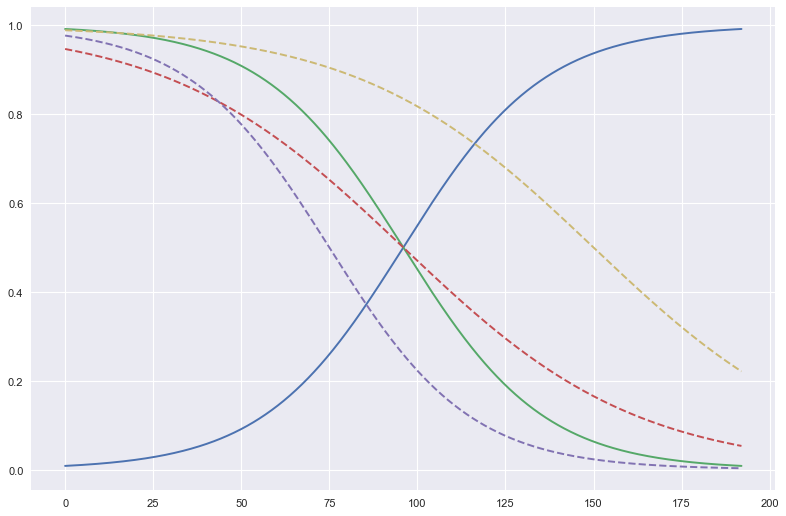

time: 197 ms


In [151]:
from scipy.special import expit
from numpy import exp

fig = plt.figure()
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w')
ax = plt.axes()

x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.05 #slope of the curve
L=1 # max y value
ax.plot(x, (L/(1+exp(-k*(x-xt)))), linestyle='-')
ax.plot(x, 1-(L/(1+exp(-k*(x-xt)))), linestyle='-')
ax.plot(x, 1-(L/(1+exp(-0.03*(x-xt)))), linestyle='--')
ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
ax.plot(x, 1-(L/(1+exp(-0.03*(x-150)))), linestyle='--')

([<matplotlib.axis.XTick at 0x11ad32668>,
 <a list of 17 Text xticklabel objects>)

<Figure size 432x288 with 0 Axes>

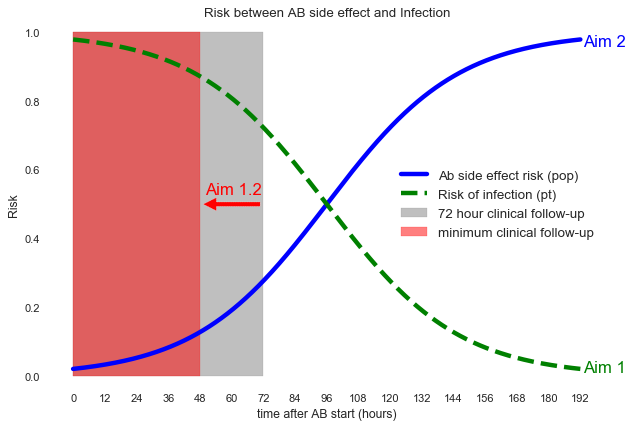

time: 351 ms


In [282]:
from scipy.special import expit
from numpy import exp
import matplotlib.patches as patches

fig = plt.figure()
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value
ax.plot(x,
        (L/(1+exp(-k*(x-xt)))),
        linestyle='-',
        linewidth=4.0,
        color='blue'
       )
ax.plot(x,
        1-(L/(1+exp(-k*(x-xt)))),
        linestyle='--',
        linewidth=4.0,
        color='green'
       )
#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot([72, 72], [0, 1], color='black', linestyle=':', linewidth=2) #og clinical time
#ax.plot([48, 48], [0, 1], color='red', linestyle=':', linewidth=2) #reduced clinical time

###annotations
ax.annotate('',
            xy=(72-24, 0.5),
            xytext=(92-20, 0.5),
            arrowprops=dict(facecolor='red',
            shrink=0.05,
            linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(183, 0.01),
            xytext=(193, 0.01),
            color='green',
            size=15
            )
# ax.annotate('Aim 1.2',
#             xy=(62, 0.49),
#             xytext=(72, 0.49),
#             color='red',
#             size=15,
#             )
ax.annotate('Aim 1.2',
            xy=(40, 0.53),
            xytext=(50, 0.53),
            color='red',
            size=15,
            )

ax.annotate('Aim 2',
            xy=(183, 0.96),
            xytext=(193, 0.96),
            color='blue',
            size=15,
            )

###rectangles
p = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p) #adds grey rectangle
p = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p)

###legend
ax.legend((
    'Ab side effect risk (pop)',
    'Risk of infection (pt)',
    '72 hour clinical follow-up',
    'minimum clinical follow-up'),
    loc= 'best', fontsize='medium')
ax.set_facecolor('white')
###plot titles & axes
ax.set_ylabel('Risk')
ax.set_xlabel('time after AB start (hours)')
ax.set_title('Risk between AB side effect and Infection')
plt.xticks(np.arange(min(x), max(x)+1, 12))

